<b>Import</b>

In [31]:
import pandas as pd
from scipy.stats import f_oneway
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

OUTPUTFCP_CSV = 'c:\\Users\\micro\\Onedrive\\Pworkspace\\sample_fcp_data_clean.csv'
OUTPUTOL_CSV = 'c:\\Users\\micro\\Onedrive\\Pworkspace\\sample_ol_data_clean.csv'

# true to run the onload sample csv
RUNOL = True

DEFAULT_SAMPLE_SIZE = 1200
OUTLIERS = 20000 if RUNOL == True else 10000
DATALABEL = "Onload" if RUNOL else "First Contentful Paint"


In [32]:


# early test
#files = ['ol_density_cookie_2017.csv']

# concat these - full world
#files = ['ol-density-cookie-2020a.csv','ol-density-cookie-2020b.csv',
#         'ol-density-cookie-2020c.csv','ol-density-cookie-2020d.csv']

# USA
#files = ['ol_density_cookie_2020us.csv']

# FCP wide
files_fcp = ['fcp_sample_1m_all_2020.csv']

# OL wide
files_ol = ['ol_sample_1m_all_2020.csv']

files = files_ol if RUNOL else files_fcp

# output files

output_fcp = OUTPUTFCP_CSV
output_ol = OUTPUTOL_CSV

output_file = output_ol if RUNOL else output_fcp

uxData = pd.read_csv(files[0])
for i in range(1,len(files)):
    uxData.append(pd.read_csv(files[i]))



In [33]:
def inMillis(x):
    return x*(pd.to_numeric(x.name))

## Finds the median in the histogram
## May need refinement if we want to use median
## The bins are big, some estimation within the bin is necessary
def findMedian(df):
    total = 0
    for k,v in df.iteritems():
        total += v
        if (total >= .5):
            return k
        
testDomains = ['https://inspirationfeed.com','https://zoeskitchen.com',
              'https://google.com','https://paysimple.com',
              'https://swifthub.com','https://paysafecash.com']

newColumns = ['origin', 'app', '200', '600', '1000', '1400', '1800', '2200',
       '2700', '3500', '4500', '5500', '6500', '7500', '8500', '9500',
       '10500', '11500', '12500', '13500', '14500', '15500', '16500',
       '17500', '18500', '19500', '25000', '35000', '45000', '55000',
       '65000', '75000', '85000', '95000', '110000', '130000']



systems = ['Didomi', 
'Iubenda',
'OneTrust',
'Cookiebot',
'Quantcast Choice',
'Osano']


<h2>Data Prep</h2

In [34]:
uxData.app = uxData.app.fillna('')
uxData = uxData.fillna(0)
uxData.columns = newColumns
uxData.head()

,origin,app,200,600,1000,1400,1800,2200,2700,3500,...,25000,35000,45000,55000,65000,75000,85000,95000,110000,130000
0,https://epinesis.net,,0.0034,0.0161,0.0154,0.0268,0.0476,0.0606,0.0958,0.1559,...,0.0112,0.0040,0.0016,0.0008,0.0005,0.0003,0.0002,0.0002,0.0002,0.0003
1,https://www.raveshop.cz,,0.0058,0.1825,0.2451,0.1648,0.1115,0.0628,0.0702,0.0739,...,0.0008,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,https://www.reimagineongs.com.br,,0.0018,0.0769,0.1470,0.1118,0.0866,0.0943,0.0804,0.0924,...,0.0083,0.0000,0.0000,0.0009,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,https://www.ofteco.com,,0.0264,0.0700,0.1906,0.1747,0.0997,0.0759,0.0700,0.0889,...,0.0034,0.0016,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,https://www.nticorp.com,,0.2526,0.1491,0.0720,0.1004,0.0567,0.0615,0.0788,0.0838,...,0.0034,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


<h2>Data Verification</h2>

In [35]:
meanDf = uxData.copy()
meanDf['median_response'] = uxData.iloc[:,2:].aggregate(findMedian, axis=1)
meanDf['sum_hist'] = uxData.iloc[:,2:].apply(inMillis).sum(axis=1).round(2) 
meanDf['sum_ratios'] = uxData.iloc[:,2:].sum(axis=1)
meanDf['mean_response'] = meanDf['sum_hist'].div(meanDf['sum_ratios'])
meanDf['mean_log'] = np.log(meanDf['mean_response'])

print (meanDf['mean_response'].skew(), meanDf['mean_log'].skew(), "\n",
       meanDf['mean_response'].mean(), meanDf['mean_log'].mean())



2.9174452812356284 0.007573128175757957 
 4190.538999273921 8.1612604037107


<h3>Check for Bad Data (not representative of 100% of users)</h3>

In [36]:
hasCookie = meanDf[meanDf['app'] != '']
badRatio = meanDf[meanDf['sum_ratios'] > 1.005]
badRatio.append(meanDf[meanDf['sum_ratios'] < 99.995])
if (len(badRatio) > 0): raise Exception("Bad Ratio")


<h3>Check for duplicated entries</h3>

In [37]:
meanDf[meanDf.duplicated()]

,origin,app,200,600,1000,1400,1800,2200,2700,3500,...,75000,85000,95000,110000,130000,median_response,sum_hist,sum_ratios,mean_response,mean_log


In [38]:

#meanDf[meanDf['app'].isin(list(systems[0]))]
#meanDf[meanDf['app'] == systems[5]]['mean_response'].mean()
#meanDf['mean_response'].mean()


<h2>Data Split</h2>

In [39]:
splitData = meanDf[meanDf['app'] != '']

splitData = splitData.set_index(['app','origin'])

appData = splitData.copy()
appData.index = appData.index.droplevel(1)

# Now data is multi-index seperated by cookie app   

<h3>Random Sample</h3>

In [40]:
# Count data entries for each app
for i in systems:
    print(i + ': ' + str(appData['mean_response'].loc[i].count()))



Didomi: 1282
Iubenda: 2047
OneTrust: 4172
Cookiebot: 4476
Quantcast Choice: 9755
Osano: 13400


In [41]:
sampleData = appData.copy()

random_state = 5

def sampleAppData(df, n = DEFAULT_SAMPLE_SIZE, items=systems):
    
    for i in range(len(items)):
        if (i == 0):
            newDf = df.loc[items[i]].sample(n=n, random_state=random_state)
        else:
            newDf = newDf.append(df.loc[items[i]].sample(n=n, random_state=random_state))
    return newDf

def stackData(df, col = 'mean_response', loc=systems, indexName='app'):
    d=pd.DataFrame();
        
    for k in loc:
        if (k == loc[0]):
            d[k] = df[col].loc[k]
            d = d.reset_index().drop(indexName,axis=1)
        else:
            d[k] = df[col].loc[k].reset_index().drop(indexName,axis=1)
        
    return d

def stackDataWoOutliers(df, col = 'mean_response', loc=systems, indexName='app', outliers=OUTLIERS):
    return stackData(df[df[col] < outliers], col, loc, indexName)

def sampleNoAppData(df, n = DEFAULT_SAMPLE_SIZE, items=systems):
    
    newDf = df[df['app'] == ''].sample(n=n, random_state=random_state)
    newDf = newDf.set_index(['app','origin'])

    newDf.index = newDf.index.droplevel(1)
    
    return newDf

sampleNoAppData = sampleNoAppData(meanDf, n=(DEFAULT_SAMPLE_SIZE * 6))
sampleData = sampleAppData(sampleData)
stackedData = stackData(sampleData)
stackedLogData = stackData(sampleData, col = 'mean_log')
stackedDataWoOutliers = stackDataWoOutliers(sampleData)
stackedLogDataWoOutliers = stackDataWoOutliers(sampleData, col = 'mean_log')

<h3>Outliers</h3>

In [42]:
#woOutliers = splitData[splitData['mean_response'] < 30000]
#woOutliers['mean_response'].max()

woOutliers = sampleData[sampleData['mean_response'] < OUTLIERS]
print("Population Mean: " + str(meanDf['mean_response'].mean()))
print("Population App Mean: " + str(meanDf[meanDf['app'].isin(systems)]['mean_response'].mean()))
print("No App Mean: " + str(sampleNoAppData['mean_response'].mean()))
print("App Mean: " + str(sampleData['mean_response'].mean()))
print("App Mean w/o outliers: " + str(woOutliers['mean_response'].mean()))
      
     # woOutliers['mean_response'].mean()



Population Mean: 4190.538999273921
Population App Mean: 5055.661713340598
No App Mean: 4193.994141377386
App Mean: 5080.750338298282
App Mean w/o outliers: 4988.320384281648


<H1>Levene</H1>
<P>Levene's test shows unequal variances. Need reference to use ANOVA regardless. Equal distribution, equal sample sizes</P>
<p>https://data.library.virginia.edu/a-rule-of-thumb-for-unequal-variances/</p>

In [43]:
from scipy.stats import levene
from scipy.stats import kruskal
from scipy.stats import wilcoxon


appMeanVariance = np.var(stackedLogData)

print(stackedLogData.columns)
stat, p = levene(stackedLogData['Didomi'],stackedLogData['Cookiebot'], stackedLogData['Quantcast Choice'],
                stackedLogData['OneTrust'], stackedLogData['Iubenda'], stackedLogData['Osano'])

#stat, p = levene(stackedLogDataWoOutliers['Didomi'], stackedLogDataWoOutliers['Cookiebot'], center = 'trimmed')
#stat, p = levene(sampleNoAppData['mean_log'], sampleData['mean_log'])
print("Levene's Test: stat: ", stat, " p: ", p)

print(appMeanVariance)


Index(['Didomi', 'Iubenda', 'OneTrust', 'Cookiebot', 'Quantcast Choice',
       'Osano'],
      dtype='object')
Levene's Test: stat:  36.413354354782186  p:  5.793557508427283e-37
Didomi              0.175536
Iubenda             0.191611
OneTrust            0.251567
Cookiebot           0.197355
Quantcast Choice    0.309622
Osano               0.328649
dtype: float64


<h2>Z-test</h2>

In [44]:
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.weightstats import zconfint

testSampleNoApp = pd.DataFrame()
testSampleApp = pd.DataFrame()

testSampleNoApp['mean_response'] = sampleNoAppData['mean_response']
testSampleApp['mean_response'] = sampleData['mean_response']
testSampleNoApp['mean_response_log'] = sampleNoAppData['mean_log']
testSampleApp['mean_response_log'] = sampleData['mean_log']

z, p = ztest( testSampleApp['mean_response_log'], x2=testSampleNoApp['mean_response_log'],\
             value = 0, alternative='two-sided')

print(z, p)
print("Test Sample:\n ", testSampleNoApp.mean(), testSampleApp.mean())


22.709962762491866 3.57144956179702e-114
Test Sample:
  mean_response        4193.994141
mean_response_log       8.163862
dtype: float64 mean_response        5080.750338
mean_response_log       8.380081
dtype: float64


<h3>Summary</h3>

In [45]:
# need to make summary function

def doSummary(df, items=systems):
    for i in range(len(items)):
        if(i==0):
            summary = pd.DataFrame(df.loc[items[i]].mean()).T
        else:
            summary = summary.append(pd.DataFrame(df.loc[items[i]].mean()).T,ignore_index=True)
    summary.index = items
    
    return summary

summary = doSummary(sampleData)
summaryWoOutliers = doSummary(woOutliers)


In [46]:
summary

,200,600,1000,1400,1800,2200,2700,3500,4500,5500,...,75000,85000,95000,110000,130000,median_response,sum_hist,sum_ratios,mean_response,mean_log
Didomi,0.001831,0.015039,0.036213,0.053481,0.064104,0.065087,0.097035,0.145441,0.115106,0.088200,...,0.000795,0.000535,0.000349,0.000424,0.000973,inf,6538.633917,0.999961,6538.852840,8.697919
Iubenda,0.010758,0.043594,0.065488,0.074228,0.077159,0.075098,0.104908,0.146289,0.107190,0.076298,...,0.000279,0.000155,0.000111,0.000145,0.000354,inf,4755.945292,0.999970,4756.082998,8.367841
OneTrust,0.017724,0.059380,0.081776,0.089205,0.086364,0.079925,0.104541,0.132256,0.090187,0.061383,...,0.000375,0.000228,0.000148,0.000181,0.000533,inf,4602.425225,0.999955,4602.652214,8.302099
Cookiebot,0.020746,0.076979,0.102794,0.106467,0.100449,0.088480,0.108716,0.127363,0.081132,0.052677,...,0.000158,0.000092,0.000060,0.000069,0.000172,inf,3606.735242,0.999969,3606.865404,8.088424
Quantcast Choice,0.011433,0.040193,0.057816,0.063545,0.064370,0.063896,0.089780,0.123272,0.093640,0.071125,...,0.001098,0.000665,0.000425,0.000540,0.001815,inf,6837.795367,0.999977,6837.868487,8.671752
Osano,0.028860,0.082824,0.098535,0.096642,0.088980,0.078733,0.098490,0.119501,0.080405,0.054746,...,0.000336,0.000210,0.000140,0.000154,0.000402,inf,4141.924117,0.999964,4142.180087,8.152450


In [47]:
summary['mean_response']

Didomi              6538.852840
Iubenda             4756.082998
OneTrust            4602.652214
Cookiebot           3606.865404
Quantcast Choice    6837.868487
Osano               4142.180087
Name: mean_response, dtype: float64

<h2>Visuals</h2>

In [48]:
## Styles

plt.rcParams['figure.dpi'] = 100

def boxPlotStyle(ax, title="Title", xlabel="X Label", ylabel="Y Label"):
    ax.axes.set_title(title, fontsize=28)
    ax.axes.set_xlabel(xlabel, fontsize=18)
    ax.tick_params(labelsize=14)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
    
def barPlotStyle(ax, title="Title", xlabel="Compliance App", ylabel="Count"):
    ax.axes.set_title(title, fontsize=20)
    ax.axes.set_xlabel(xlabel, fontsize=18)
    ax.tick_params(labelsize=10)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    ax.margins(.25)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), 'd'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0,9),
                   textcoords = 'offset points')

def kdePlot(df, bounds=None, title="Distribution", xlabel="Mean Response Time", ylabel="Density"):
    # Z-test log displot
    plt.figure(figsize=(16,16), dpi=100)
    plt.rcParams['figure.dpi'] = 150
    ax = sns.displot(df, kind='kde')
    #ax.legend()
    ax.set_axis_labels(xlabel, ylabel)
    ax.set_titles(title)
    if (bounds != None):
        ax.set(xlim=bounds)
    plt.show()


<li>Count of websites using app</li>

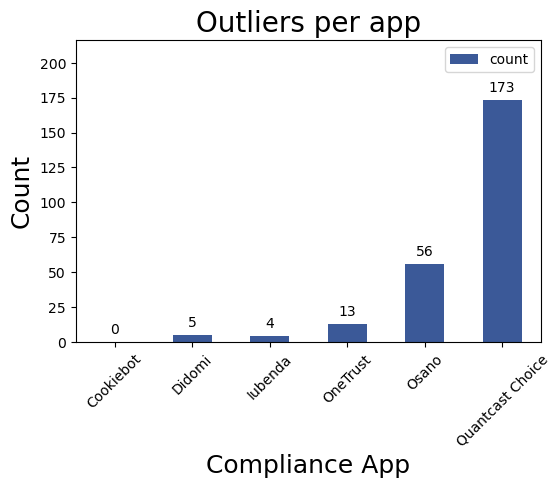

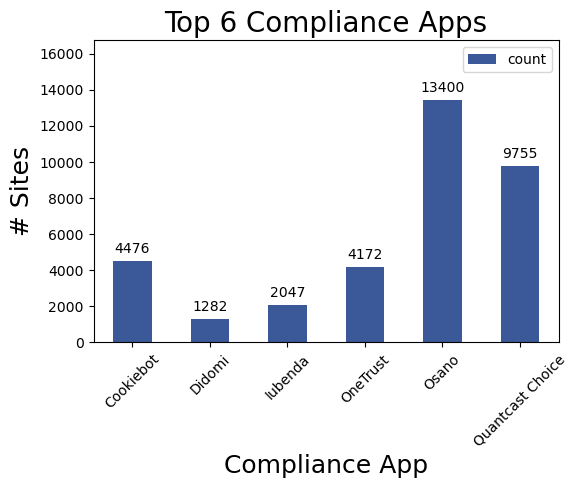

In [49]:
def countApps(df, items=systems, outliers=0):
    d = df.copy()
    d = d[d['mean_response'] > outliers].loc[items].count(level=0).reset_index()
    return d[d['app'].isin(items)]

# outliers
ax = countApps(splitData.copy(), outliers=OUTLIERS).plot(
    y='mean_response',x='app',kind='bar',label='count',color='#3b5998')
barPlotStyle(ax, title="Outliers per app" )

# total
ax = countApps(splitData, outliers=0).plot(
    y='mean_response',x='app',kind='bar',label='count',color='#3b5998')
barPlotStyle(ax, title="Top 6 Compliance Apps", ylabel="# Sites")


<li>Box Plots</li>

<lu>Sample Data Outlier test</lu>

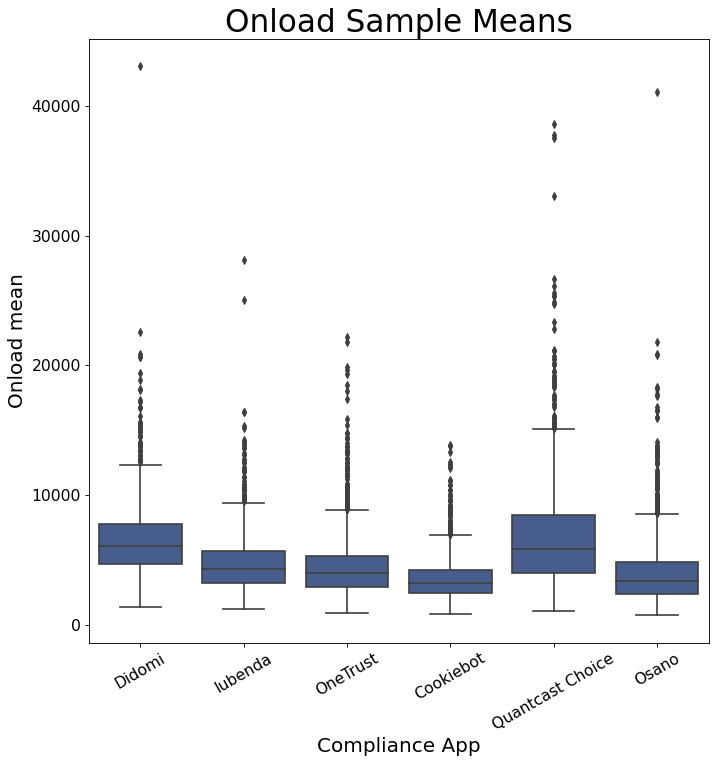

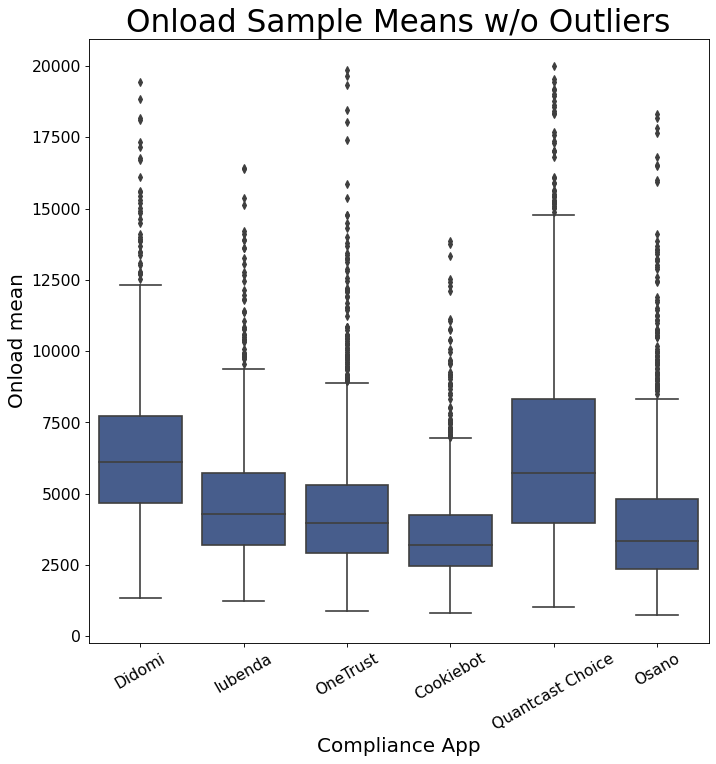

In [50]:
def snsb(df, outliers=2_000_000, title=DATALABEL + " Sample Means"):
    plt.figure(figsize=(10,10), dpi=80)
    sData = pd.melt(df[df['mean_response'] < outliers].reset_index(), id_vars=['app'], value_vars=['mean_response'], value_name='mean')
    ax = sns.boxplot(x='app', y='mean', data=sData, color='#3b5998')
    boxPlotStyle(ax, title=title, xlabel="Compliance App", ylabel=DATALABEL + " mean")
    plt.show()

    
snsb(sampleData)
snsb(sampleData, outliers=OUTLIERS, title=DATALABEL + " Sample Means w/o Outliers")


<lu>Full Data Outlier Test</lu>

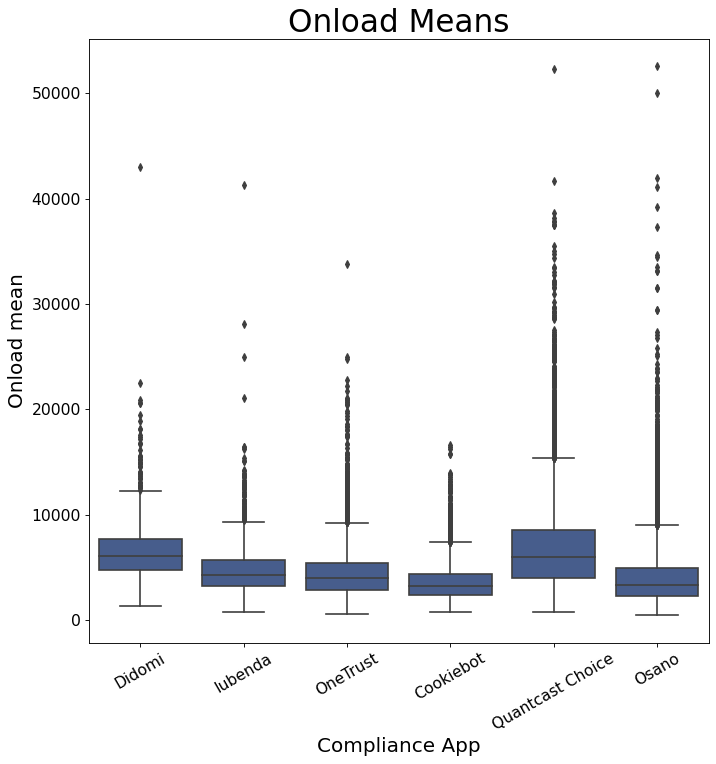

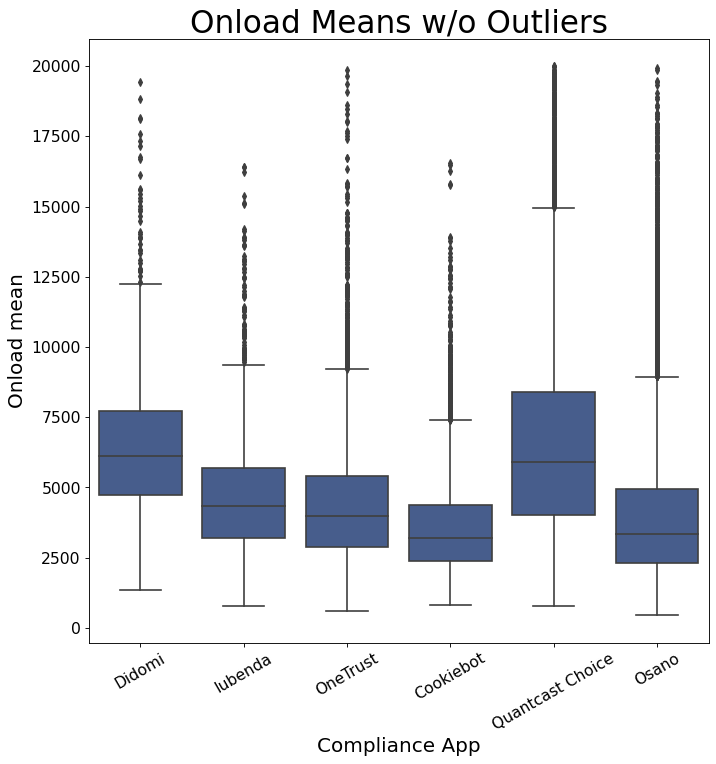

In [51]:
snsb(appData.loc[systems], title=DATALABEL + " Means")
snsb(appData.loc[systems], OUTLIERS, title=DATALABEL + " Means w/o Outliers")


<li>Histogram</li>

<ul>sample</ul>

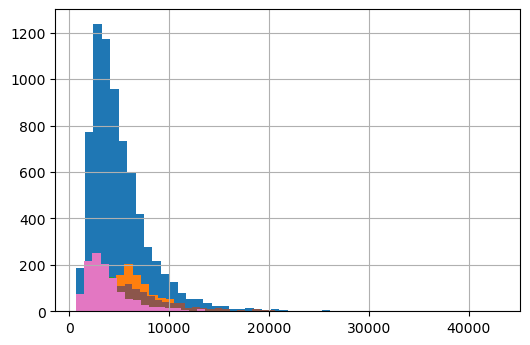

In [52]:
def buildHist(df, outliers=OUTLIERS):
    df.sort_values().hist(bins=50)

def buildDist(df, outliers=OUTLIERS):
    df.sort_values().distplot()

#buildDist(sampleData.loc[systems]['mean_response'])
    
buildHist(sampleData.loc[systems]['mean_response'])
for s in systems:
    buildHist(sampleData.loc[s]['mean_response'])

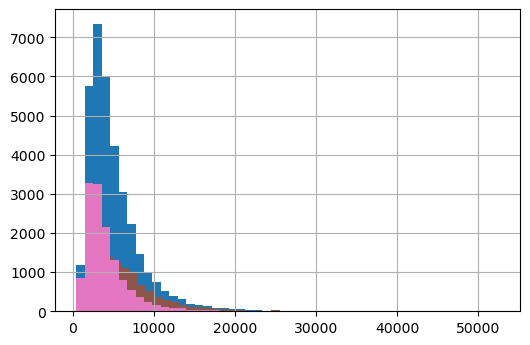

In [53]:
buildHist(appData.loc[systems]['mean_response'])
for s in systems:
    buildHist(appData.loc[s]['mean_response'])

<AxesSubplot:>

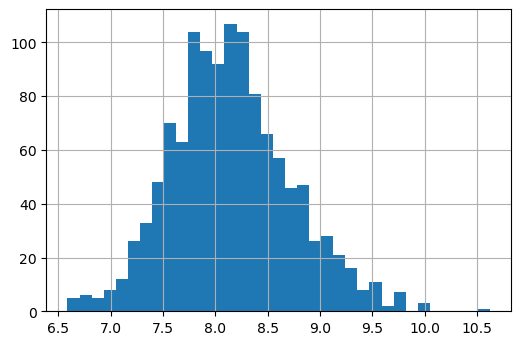

In [54]:
#splitData.loc['Didomi']['mean_response'].sort_values().hist()
sampleData.loc[systems[5]]['mean_log'].sort_values().hist(bins=35)


<H2>Distribution Plots</H2>
<P>Distribution plots to check for normality. Log Transform is plotted as well and determined to be used for tests</P>


<Figure size 1600x1600 with 0 Axes>

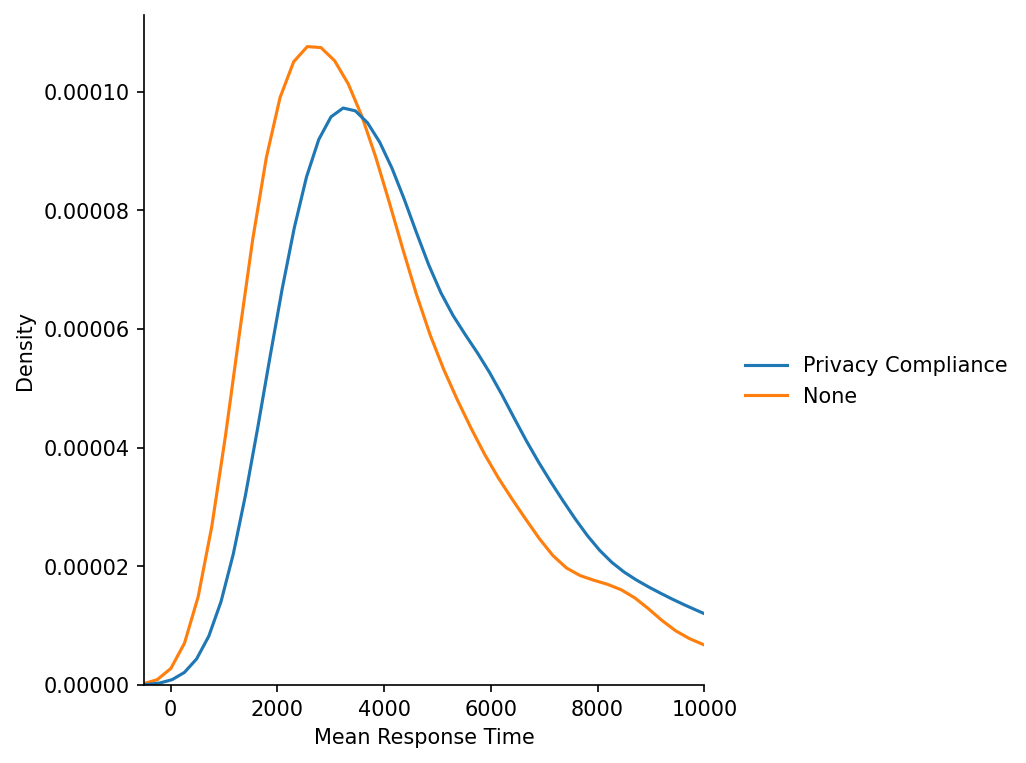

<Figure size 1600x1600 with 0 Axes>

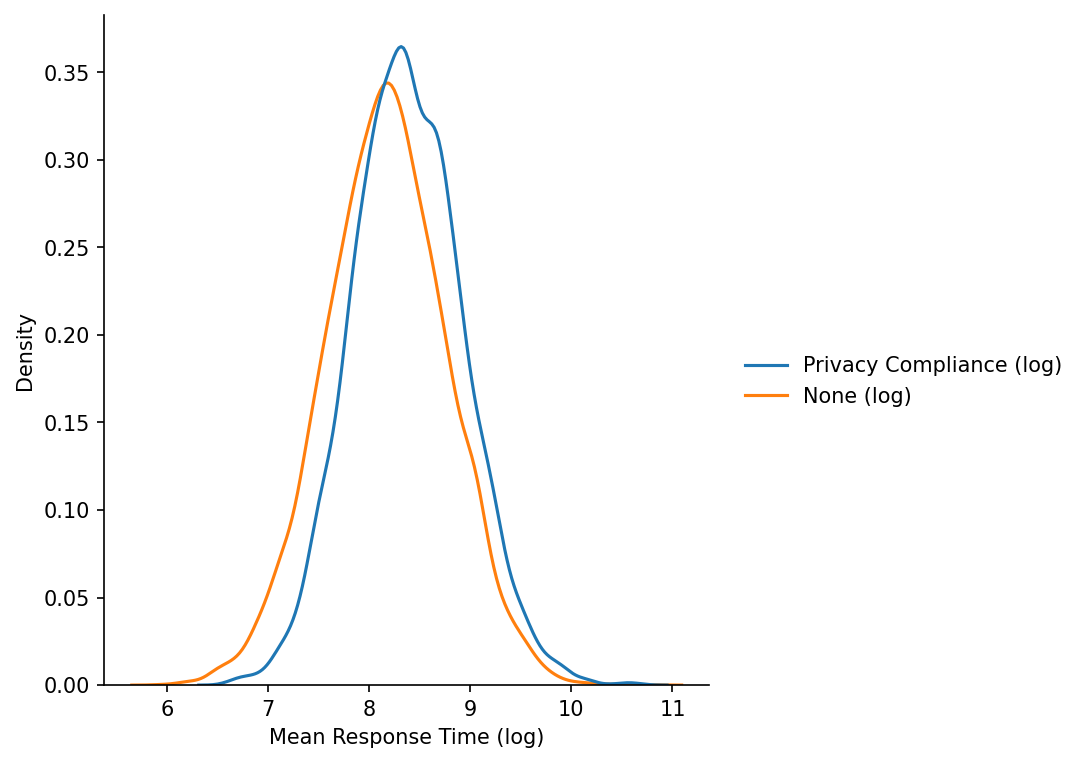

In [25]:

zplot = pd.DataFrame()
zplot_log = pd.DataFrame()
zplot['Privacy Compliance'] = testSampleApp.reset_index()['mean_response']
zplot['None'] = testSampleNoApp.reset_index()['mean_response']
zplot_log['Privacy Compliance (log)'] = np.log(testSampleApp.reset_index()['mean_response'])
zplot_log['None (log)'] = np.log(testSampleNoApp.reset_index()['mean_response'])


# Z-test displot
kdePlot(zplot, bounds=(-500,10000))
# Z-test log displot
kdePlot(zplot_log, xlabel="Mean Response Time (log)")

<Figure size 1600x1600 with 0 Axes>

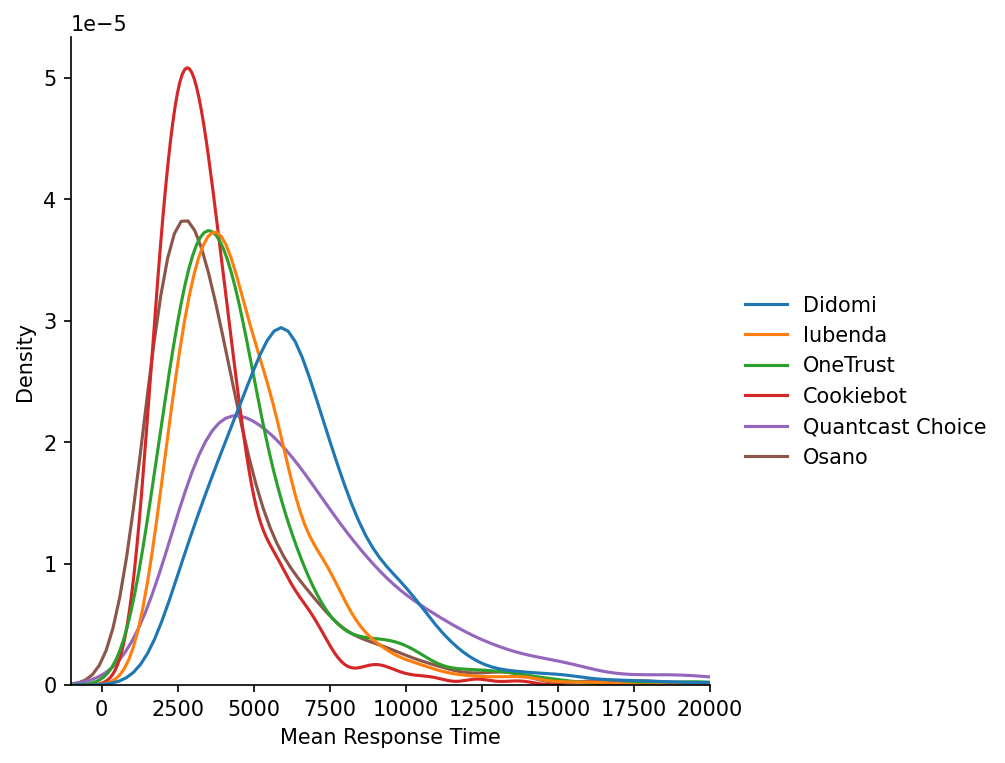

<Figure size 1600x1600 with 0 Axes>

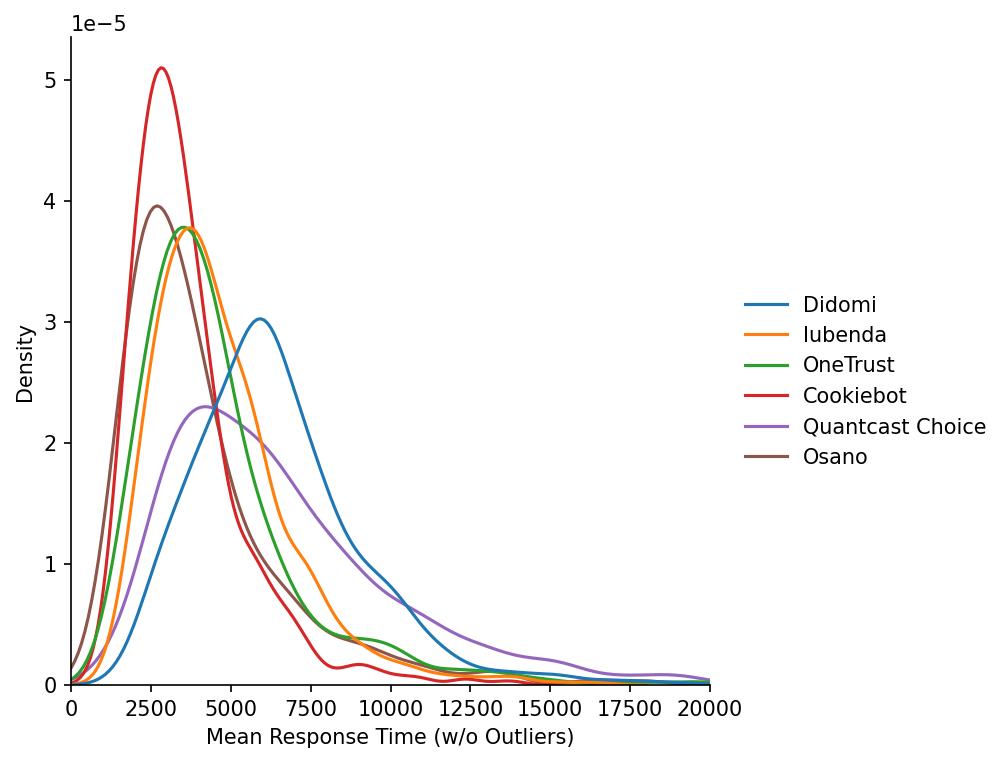

<Figure size 1600x1600 with 0 Axes>

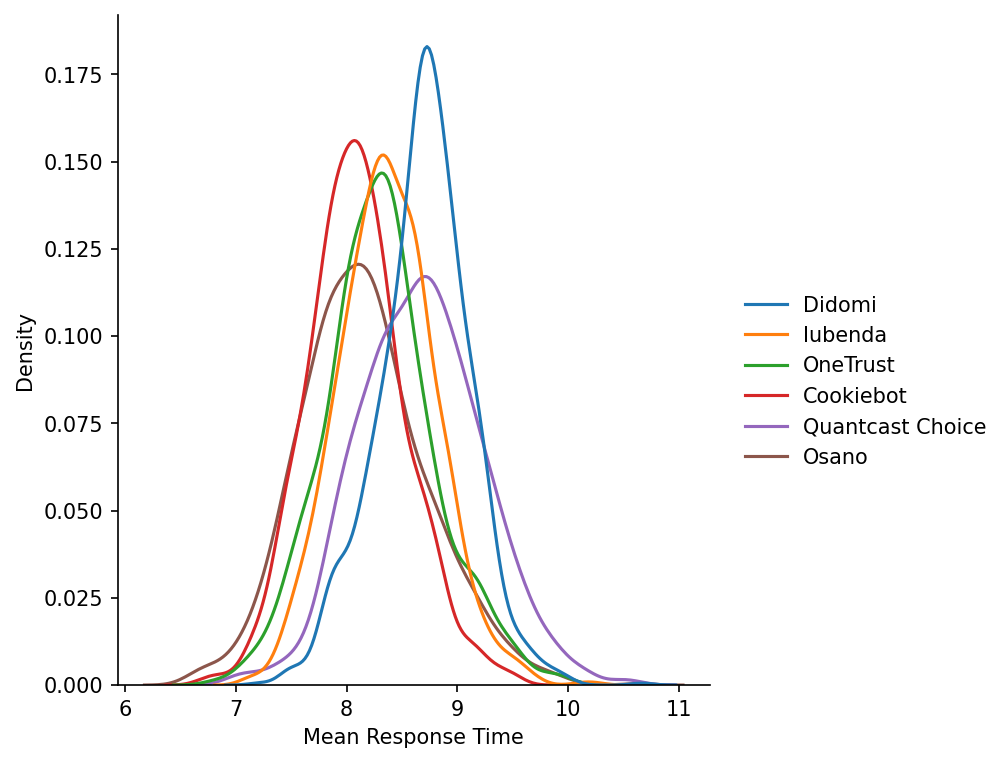

<Figure size 1600x1600 with 0 Axes>

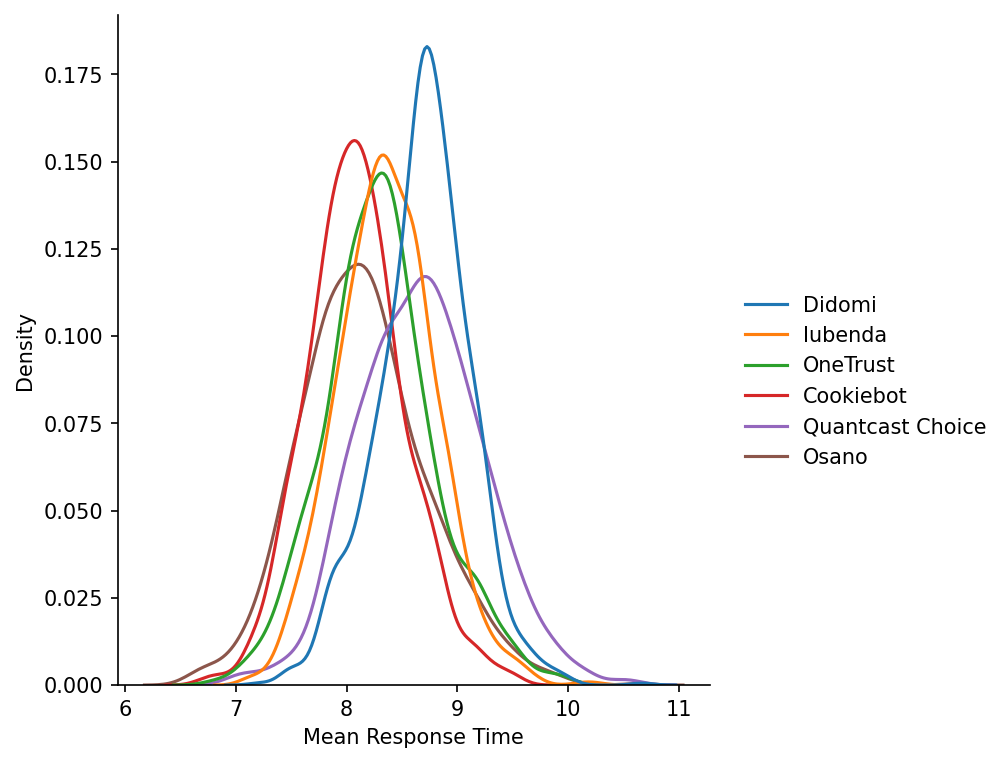

In [26]:
#sampleData.loc[systems[5]]['mean_response'].sort_values().plot.kde()
#sampleData.loc[systems[4]]['mean_response'].sort_values().plot.kde()
#sampleData.loc[systems[3]]['mean_response'].sort_values().plot.kde()

xlim_ol_outliers = (-1000,20000)
xlim_ol_wooutliers = (0,20000)

xlim_fcp_outliers = (-1000, 6000)
xlim_fcp_wooutliers = (0, 10000)

xlim_outliers = xlim_ol_outliers if RUNOL else xlim_fcp_outliers
xlim_wooutliers = xlim_ol_wooutliers if RUNOL else xlim_fcp_wooutliers

# All apps
kdePlot(stackedData[systems], bounds=xlim_outliers)
# All apps, w/o outliers
kdePlot(stackedDataWoOutliers[systems], bounds=xlim_wooutliers, xlabel="Mean Response Time (w/o Outliers)")

# All apps, log transform
kdePlot(stackedLogData[systems])
# All apps, w/o outliers, log transform
kdePlot(stackedLogDataWoOutliers[systems])

In [27]:
#meanDf[meanDf['origin']=='https://100percentfedup.com'].iloc[:,2:-3].apply(inMillis).T
#sampleData

<h1>Tests</h1>

<h2>ANOVA</h2>

In [28]:
#from scipy.stats import f_oneway

anova = f_oneway(
    sampleData['mean_response'].loc[systems[0]],
    sampleData['mean_response'].loc[systems[1]],
    sampleData['mean_response'].loc[systems[2]],
    sampleData['mean_response'].loc[systems[3]],
    sampleData['mean_response'].loc[systems[4]],
    sampleData['mean_response'].loc[systems[5]]
    
)

anova_log = f_oneway(
    sampleData['mean_log'].loc[systems[0]],
    sampleData['mean_log'].loc[systems[1]],
    sampleData['mean_log'].loc[systems[2]],
    sampleData['mean_log'].loc[systems[3]],
    sampleData['mean_log'].loc[systems[4]],
    sampleData['mean_log'].loc[systems[5]]
    
)

single = f_oneway(
    sampleData['mean_log'].loc[systems[5]],
    meanDf['mean_log'])

print(single, '\n', anova, "\n", anova_log)



F_onewayResult(statistic=0.2612361250169193, pvalue=0.6092723024179376) 
 F_onewayResult(statistic=237.6259716691258, pvalue=1.4314894244817674e-235) 
 F_onewayResult(statistic=325.6859473207123, pvalue=2.251312644e-315)


<h2>Tukey</h2>

<p>Comparison of means between Cookie App repsonse times across sample. Due to size of sample and possible outside influeance, a significance level of <b>99%</b> has been used.</p>

       Multiple Comparison of Means - Tukey HSD, FWER=0.01       
  group1       group2      meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------
Cookiebot           Didomi   0.6095  0.001  0.5418  0.6772   True
Cookiebot          Iubenda   0.2794  0.001  0.2118  0.3471   True
Cookiebot         OneTrust   0.2137  0.001   0.146  0.2813   True
Cookiebot            Osano    0.064 0.0183 -0.0036  0.1317  False
Cookiebot Quantcast Choice   0.5833  0.001  0.5157   0.651   True
   Didomi          Iubenda  -0.3301  0.001 -0.3977 -0.2624   True
   Didomi         OneTrust  -0.3958  0.001 -0.4635 -0.3282   True
   Didomi            Osano  -0.5455  0.001 -0.6131 -0.4778   True
   Didomi Quantcast Choice  -0.0262 0.7574 -0.0938  0.0415  False
  Iubenda         OneTrust  -0.0657 0.0138 -0.1334  0.0019  False
  Iubenda            Osano  -0.2154  0.001 -0.2831 -0.1477   True
  Iubenda Quantcast Choice   0.3039  0.001  0.2362  0.3716   True
 OneTrust 

C:\Users\micro\anaconda3\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


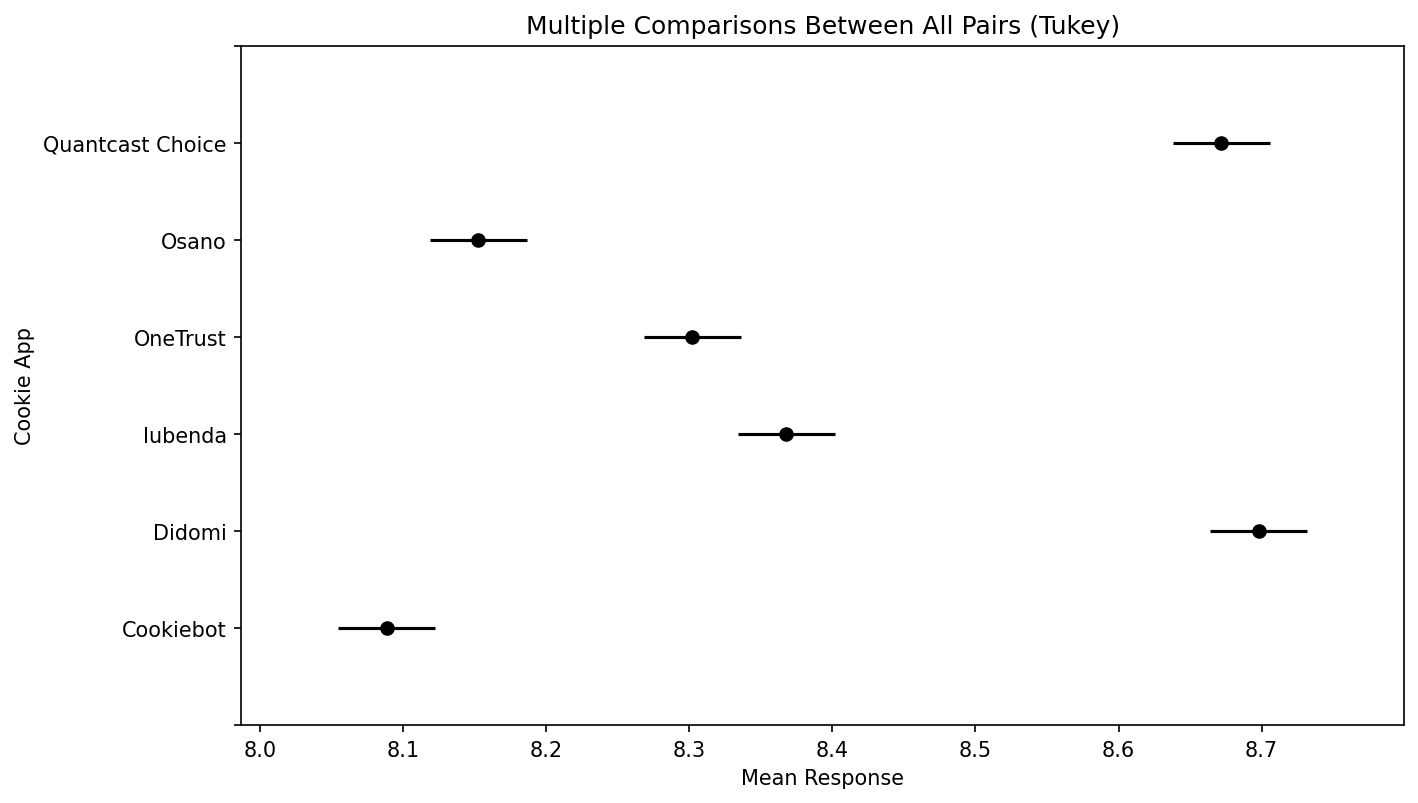

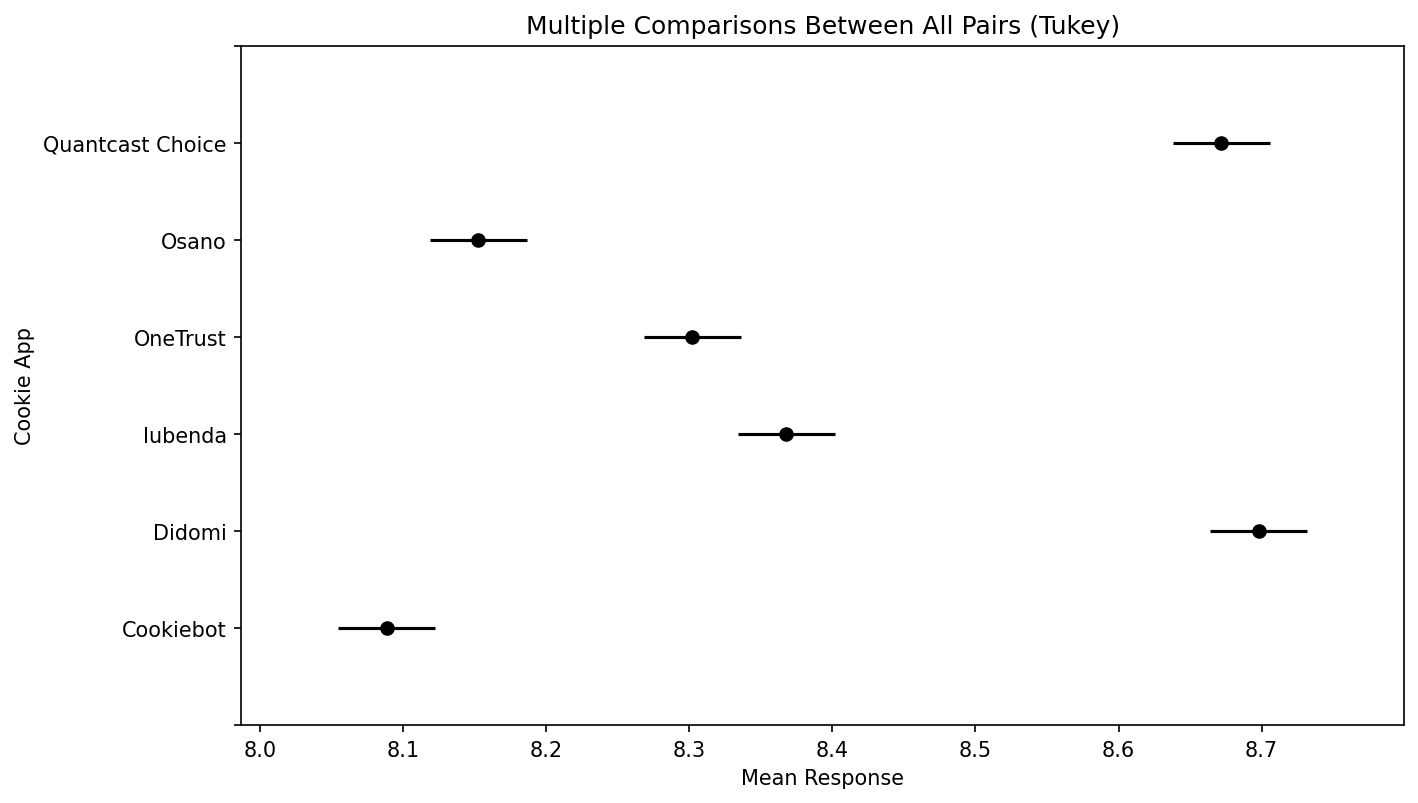

In [29]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)



sData = stackData(sampleData, col = 'mean_log').stack().reset_index()

sData.columns = ['id', 'app', 'mean_response']

        
tukeyResult = MultiComparison(sData['mean_response'],
                            sData['app'])

print(tukeyResult.tukeyhsd(alpha=.01).summary())

tukeyResult.tukeyhsd(alpha=.01).plot_simultaneous(xlabel='Mean Response', ylabel='Cookie App')

# Ok, do correlation table with a flag for pvalue

<h1>Export</h1>

In [30]:
sampleData.to_csv(output_file)